<a href="https://colab.research.google.com/github/eisenjulian/slides/blob/master/NN_from_scratch/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks in 100 lines of pure Python
----

> Can we build a Deep learning framework in pure Python and Numpy? Can we make it compact, clear and extendable? Let's set out to explore those ideas and see what we can create!

This is the companion notebook for the blogpost at [eisenjulian.github.io/deep-learning-in-100-lines](https://eisenjulian.github.io/deep-learning-in-100-lines)

## Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Base Classes

In [0]:
class Parameter():
  def __init__(self, tensor):
    self.tensor = tensor
    self.gradient = np.zeros_like(self.tensor)

class Layer:
  def __init__(self):
    self.parameters = []

  def forward(self, X):
    return X, lambda D: D

  def build_param(self, tensor):
    param = Parameter(tensor)
    self.parameters.append(param)
    return param

  def update(self, optimizer):
    for param in self.parameters: optimizer.update(param)

class Linear(Layer):
  def __init__(self, inputs, outputs):
    super().__init__()
    self.weights = self.build_param(np.random.randn(inputs, outputs) * np.sqrt(1 / inputs))
    self.bias = self.build_param(np.zeros(outputs))
    
  def forward(self, X):
    def backward(D):
      self.weights.gradient += X.T @ D
      self.bias.gradient += D.sum(axis=0)
      return D @ self.weights.tensor.T
    return X @ self.weights.tensor + self.bias.tensor, backward
  
class Sequential(Layer):
  def __init__(self, *layers):
    super().__init__()
    self.layers = layers
    for layer in layers:
      self.parameters.extend(layer.parameters)
    
  def forward(self, X):
    backprops = []
    Y = X
    for layer in self.layers:
      Y, backprop = layer.forward(Y)
      backprops.append(backprop)
    def backward(D):
      for backprop in reversed(backprops):
        D = backprop(D)
      return D
    return Y, backward

## Activations

In [0]:
class ReLu(Layer):
  def forward(self, X):
    mask = X > 0
    return X * mask, lambda D: D * mask
  
class Sigmoid(Layer):
  def forward(self, X):
    S = 1 / (1 + np.exp(-X))
    def backward(D):
      return D * S * (1 - S)
    return S, backward

## Loss Functions

In [0]:
def mse_loss(Y_, Y):
  diff = Y_ - Y.reshape(Y_.shape)
  return np.square(diff).mean(), 2 * diff / len(diff)
  
def ce_loss(Y_, Y):
  num = np.exp(Y_)
  den = num.sum(axis=1).reshape(-1, 1)
  prob = num / den
  log_den = np.log(den)
  ce = np.inner(Y_ - log_den, Y)
  return ce.mean(), Y - prob / len(Y)

## Optimizers

In [0]:
class SGDOptimizer():
  def __init__(self, lr=0.1):
    self.lr = lr

  def update(self, param):
    param.tensor -= self.lr * param.gradient
    param.gradient.fill(0)

## The training loop

In [0]:
class Learner():
  def __init__(self, model, loss, optimizer):
    self.model = model
    self.loss = loss
    self.optimizer = optimizer
      
  def fit_batch(self, X, Y):
    Y_, backward = self.model.forward(X)
    L, D = self.loss(Y_, Y)
    backward(D)
    self.model.update(self.optimizer)
    return L
    
  def fit(self, X, Y, epochs, bs):
    losses = []
    for epoch in range(epochs):
      p = np.random.permutation(len(X))
      L = 0
      for i in range(0, len(X), bs):
        X_batch = X[p[i:i + bs]]
        Y_batch = Y[p[i:i + bs]]
        L += self.fit_batch(X_batch, Y_batch)
      losses.append(L)
    return losses

## See it in action!

Weight Matrix Error 0.00441108652121308
Bias error 0.0009639927943846383


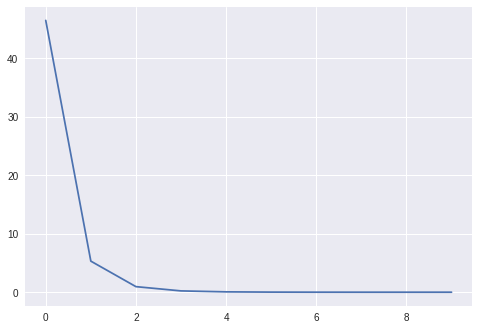

In [104]:
#@title A simple linear dataset
num_features = 10 #@param {type:"slider", min:5, max:100, step:1}
num_samples = 100 #@param {type:"slider", min:10, max:1000, step:1}
epochs = 10 #@param {type:"slider", min:1, max:100, step:1}
batch_size = 10 #@param {type:"slider", min:1, max:100, step:1}
learning_rate = 0.05 #@param {type:"slider", min:0.001, max:1.0, step:0.001}

m = Linear(num_features, 1)
model = Sequential(m)
l = Learner(model, mse_loss, SGDOptimizer(lr=learning_rate))
X = np.random.randn(num_samples, num_features)
W = np.random.randn(num_features, 1)
B = np.random.randn(1)
Y = X @ W + B + 0.01 * np.random.randn(num_samples, 1)
plt.plot(l.fit(X, Y, epochs=epochs, bs=batch_size))
print('Weight Matrix Error', np.linalg.norm(m.weights.tensor - W))
print('Bias error', np.abs(m.bias.tensor - B)[0])

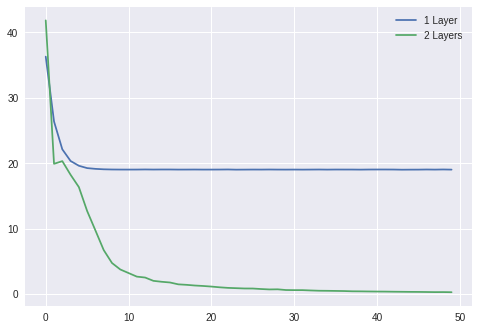

In [105]:
#@title A non-linear dataset
num_samples = 1000 #@param {type:"slider", min:100, max:10000, step:1}
epochs = 50 #@param {type:"slider", min:1, max:200, step:1}

one_layer_batch_size = 50 #@param {type:"slider", min:1, max:100, step:1}
one_layer_learning_rate = 0.01 #@param {type:"slider", min:0.001, max:1.0, step:0.001}

two_layer_batch_size = 50 #@param {type:"slider", min:1, max:100, step:1}
two_layer_learning_rate = 0.3 #@param {type:"slider", min:0.001, max:1.0, step:0.001}
hidden_neurons = 10 #@param {type:"slider", min:1, max:200, step:1}

X = np.random.randn(num_samples, 2)
Y = X[:, 0] * X[:, 1]

losses1 = Learner(
    Sequential(Linear(2, 1)), 
    mse_loss, 
    SGDOptimizer(lr=one_layer_learning_rate)
).fit(X, Y, epochs=epochs, bs=one_layer_batch_size)

losses2 = Learner(
    Sequential(
        Linear(2, hidden_neurons), 
        Sigmoid(), 
        Linear(hidden_neurons, 1)
    ), 
    mse_loss, 
    SGDOptimizer(lr=two_layer_learning_rate)
).fit(X, Y, epochs=epochs, bs=two_layer_batch_size)

plt.plot(losses1)
plt.plot(losses2)
plt.legend(['1 Layer', '2 Layers'])
plt.show()

## Wrapping Up
I hope you have found this educative, we only defined three types of layers and one loss function, so there's much more to be done. In a follow up post we will implement binary cross entropy loss as well as other non-linear activations to start building more expressive models. Stay tuned...
Reach out on Twitter at [@eisenjulian](https://twitter.com/eisenjulian) for questions and requests. Thanks for reading!